In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer
import folium
from folium.plugins import HeatMap

In [2]:
import pandas as pd

# Load the four datasets
df_2023_part1 = pd.read_csv("Crime_Data_2023_Part_1.csv")
df_2023_part2 = pd.read_csv("Crime_Data_2023_Part_2.csv")
df_2024_part1 = pd.read_csv("Crime_Data_2024_Part_1.csv")
df_2024_part2 = pd.read_csv("Crime_Data_2024_Part_2.csv")

# Combine all datasets
crime_data = pd.concat([df_2023_part1, df_2023_part2, df_2024_part1, df_2024_part2], ignore_index=True)

In [4]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22997 entries, 0 to 22996
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   X              22684 non-null  float64
 1   Y              22684 non-null  float64
 2   DATEEND        22997 non-null  object 
 3   TIMESTART      22997 non-null  object 
 4   TIMEEND        22997 non-null  int64  
 5   ADDRESS        22997 non-null  object 
 6   Arrest         2415 non-null   object 
 7   LarcenyCode    9377 non-null   object 
 8   CODE_DEFINED   22997 non-null  object 
 9   LAT            22684 non-null  float64
 10  LONG           22684 non-null  float64
 11  ObjectId       22997 non-null  int64  
 12  QualityOfLife  11331 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 2.3+ MB


In [5]:
crime_data.head()

,X,Y,DATEEND,TIMESTART,TIMEEND,ADDRESS,Arrest,LarcenyCode,CODE_DEFINED,LAT,LONG,ObjectId,QualityOfLife
0,-8.479620e+06,5.322322e+06,2023/04/27 00:00:00+00,2021,2021,1 DESTINY USA DR,NaN,Purse Snatch,LARCENY,43.067961,-76.173723,1,NaN
1,-8.477376e+06,5.319388e+06,2023/09/16 00:00:00+00,2002,2002,0 S CLINTON ST & W FAYETTE ST,NaN,All Other,LARCENY,43.048701,-76.153563,2,NaN
2,-8.479620e+06,5.322322e+06,2023/12/01 00:00:00+00,1419,1427,1 DESTINY USA DR,NaN,Shoplifting,LARCENY,43.067961,-76.173723,3,NaN
3,-8.475493e+06,5.318469e+06,2023/06/10 00:00:00+00,1847,1847,0 S CROUSE AV & E ADAMS ST,NaN,Motor Vehicle,MV THEFT,43.042671,-76.136647,4,NaN
4,-8.479620e+06,5.322322e+06,2023/08/24 00:00:00+00,1341,1341,1 DESTINY USA DR,Yes,Shoplifting,LARCENY,43.067961,-76.173723,5,NaN


In [6]:
crime_data.isnull().sum()

,0
X,313
Y,313
DATEEND,0
TIMESTART,0
TIMEEND,0
ADDRESS,0
Arrest,20582
LarcenyCode,13620
CODE_DEFINED,0
LAT,313


In [7]:
# Drop rows with missing latitude or longitude
crime_data = crime_data.dropna(subset=['LAT', 'LONG'])

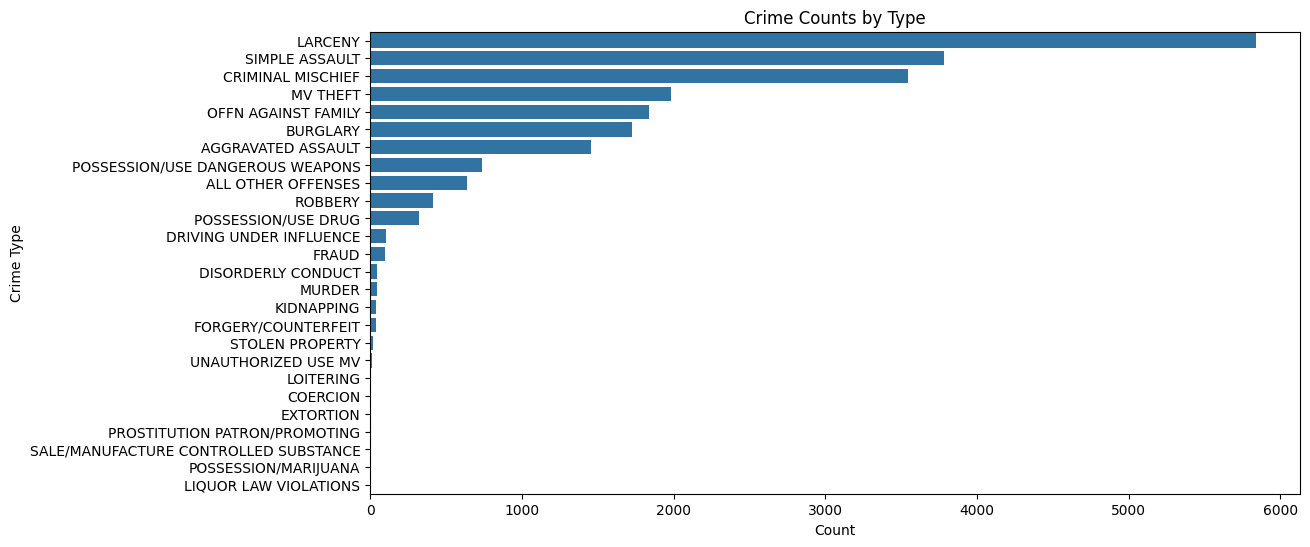

In [8]:
# Visualize crime categories
plt.figure(figsize=(12, 6))
sns.countplot(y='CODE_DEFINED', data=crime_data, order=crime_data['CODE_DEFINED'].value_counts().index)
plt.title('Crime Counts by Type')
plt.xlabel('Count')
plt.ylabel('Crime Type')
plt.show()

### Feature Engineering

In [9]:
# Convert 'DATEEND' to datetime and extract useful features like year, month, and hour
crime_data['DATEEND'] = pd.to_datetime(crime_data['DATEEND'])
crime_data['Year'] = crime_data['DATEEND'].dt.year
crime_data['Month'] = crime_data['DATEEND'].dt.month
crime_data['Day'] = crime_data['DATEEND'].dt.day
crime_data['Hour'] = pd.to_numeric(crime_data['TIMESTART'], errors='coerce') // 100  # Convert time to hour format

In [10]:
# Impute missing values in the 'Hour' column (replace NaN values with the median value)
imputer = SimpleImputer(strategy='median')
crime_data['Hour'] = imputer.fit_transform(crime_data[['Hour']])

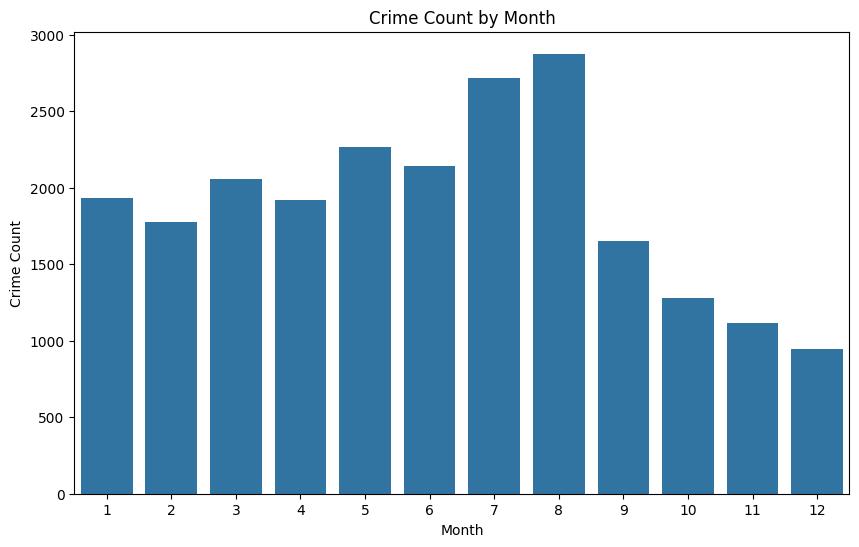

In [11]:
# Crime occurrence over time
plt.figure(figsize=(10, 6))
sns.countplot(x='Month', data=crime_data)
plt.title('Crime Count by Month')
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.show()

In [12]:
# Create a heatmap of crime hotspots using Latitude and Longitude
# Filter data for a specific year (e.g., 2023)
crime_data_2023 = crime_data[crime_data['Year'] == 2023]

# Generate a Folium map with crime hotspots
map_syracuse = folium.Map(location=[43.0481, -76.1474], zoom_start=12)

# Create a list of latitude and longitude
heat_data = [[row['LAT'], row['LONG']] for index, row in crime_data_2023.iterrows()]

# Add the heatmap layer
HeatMap(heat_data).add_to(map_syracuse)

# Save and display the map
map_syracuse.save('syracuse_crime_hotspot_map.html')
print("Crime Hotspot Map saved as 'syracuse_crime_hotspot_map.html'")

Crime Hotspot Map saved as 'syracuse_crime_hotspot_map.html'


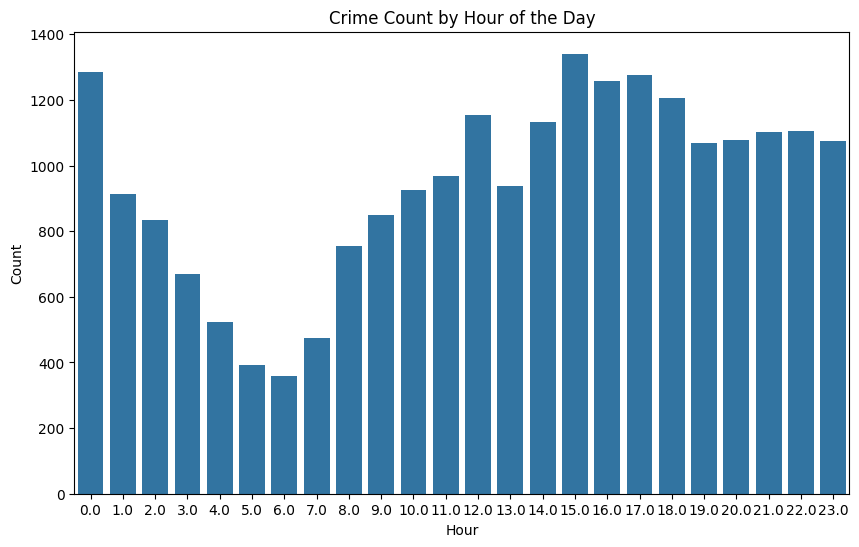

In [13]:
# Time of Day Analysis - When are most crimes committed?
plt.figure(figsize=(10, 6))
sns.countplot(x='Hour', data=crime_data)
plt.title('Crime Count by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.show()

In [18]:
# Prepare data for crime severity prediction
# Assuming 'CODE_DEFINED' as the target, we will predict severity by categorizing offenses into major and minor
# Create a severity column: categorize crimes as "Major" or "Minor" based on offense type

def categorize_severity(offense):
    major_crimes = ['EXTORTION ', 'ROBBERY', 'ASSAULT', 'BURGLARY', 'MURDER', 'AGGRAVATED ASSAULT', 'KIDNAPPING', 'MV THEFT', 'SALE/MANUFACTURE CONTROLLED SUBSTANCE']
    if offense in major_crimes:
        return 'Major'
    else:
        return 'Minor'

crime_data['Severity'] = crime_data['CODE_DEFINED'].apply(categorize_severity)

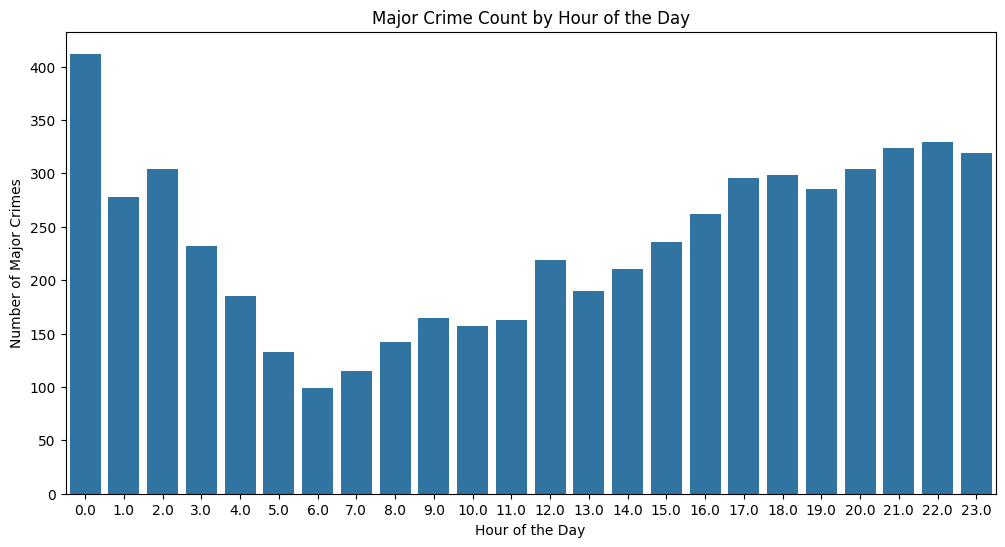

In [19]:
# Time of Day Analysis - When are most major crimes committed?

import matplotlib.pyplot as plt
import seaborn as sns

# Filter for major crimes only
major_crimes_data = crime_data[crime_data['Severity'] == 'Major']

# Plot the time frame of major crimes
plt.figure(figsize=(12, 6))
sns.countplot(x='Hour', data=major_crimes_data)
plt.title('Major Crime Count by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Major Crimes')
plt.show()

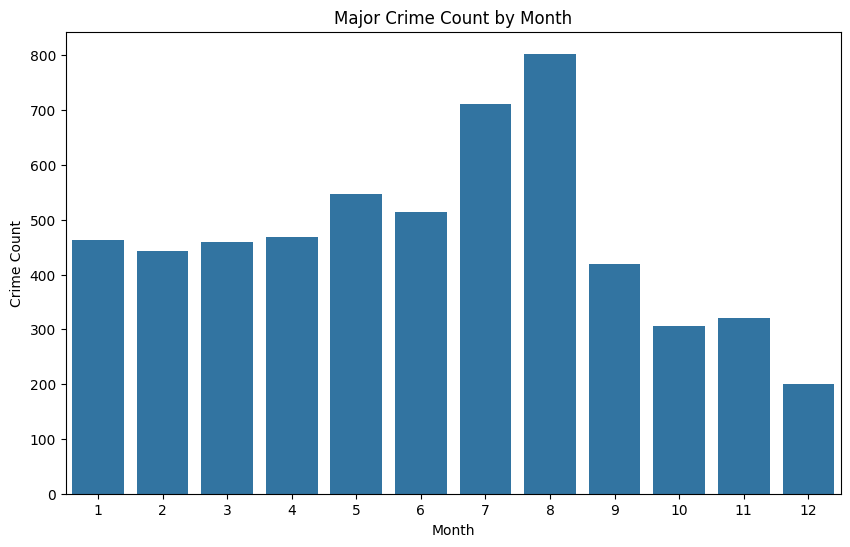

In [20]:
# Major Crime occurrence over time
plt.figure(figsize=(10, 6))
sns.countplot(x='Month', data=major_crimes_data)
plt.title('Major Crime Count by Month')
plt.xlabel('Month')
plt.ylabel('Crime Count')
plt.show()

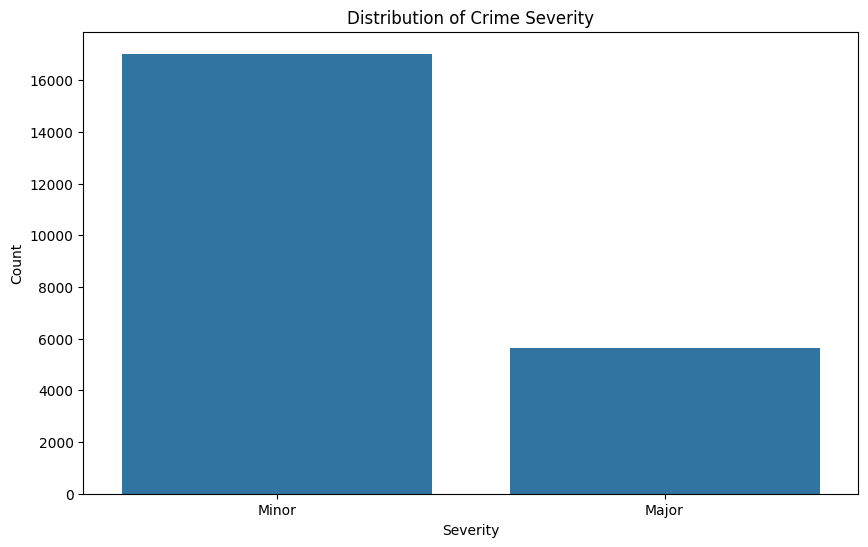

In [21]:
# Visualize crime severity distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Severity', data=crime_data)
plt.title('Distribution of Crime Severity')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()

### Model Building

In [22]:
# Encode categorical columns (Offense, Severity) and prepare features
crime_data_encoded = pd.get_dummies(crime_data, columns=['CODE_DEFINED'])

# Define features (using latitude, longitude, time features) and target ('Severity')
X = crime_data_encoded[['LAT', 'LONG', 'Month', 'Day', 'Hour']]
y = crime_data['Severity']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Random Forest

In [32]:
# Train a Random Forest classifier to predict crime severity
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = rf_classifier.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Classification Report:
              precision    recall  f1-score   support

       Major       0.38      0.09      0.14      1120
       Minor       0.76      0.95      0.85      3417

    accuracy                           0.74      4537
   macro avg       0.57      0.52      0.49      4537
weighted avg       0.67      0.74      0.67      4537

Model Accuracy: 73.93%


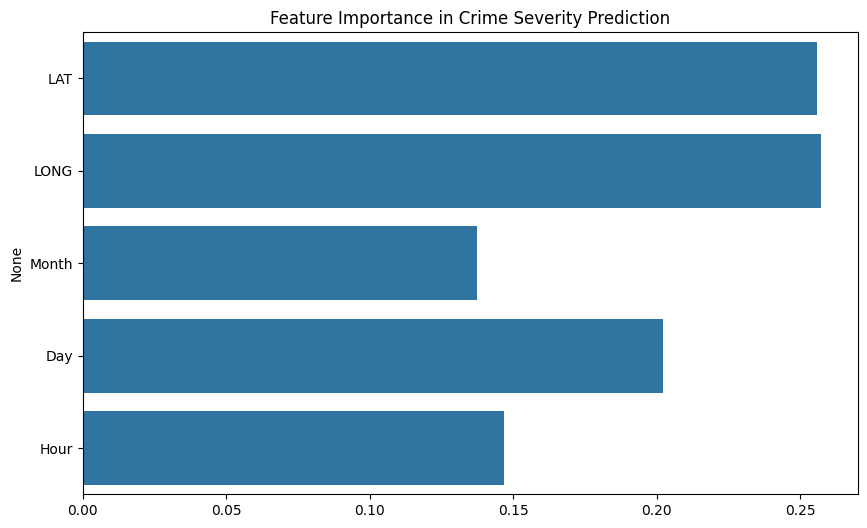

In [24]:
# Feature importance visualization
importances = rf_classifier.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance in Crime Severity Prediction')
plt.show()

In [34]:
# Crime prediction example - Predicting crime severity for a new entry

# Example input: Latitude, Longitude, Month=June (6), Day=15, Hour=14:00
new_crime = pd.DataFrame({
    'LAT': [43.0481],
    'LONG': [-76.1474],
    'Month': [8],
    'Day': [15],
    'Hour': [00]
})

# Predict the severity of the new crime
predicted_severity = rf_classifier.predict(new_crime)
print(f"Predicted Crime Severity for the new crime entry: {predicted_severity[0]}")

Predicted Crime Severity for the new crime entry: Minor


#### Gradient Boosting

In [26]:
from sklearn.ensemble import GradientBoostingClassifier
# from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)


# Train a Gradient Boosting Classifier
GBC = GradientBoostingClassifier(random_state=42)
GBC.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = GBC.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Classification Report:
              precision    recall  f1-score   support

       Major       0.30      0.54      0.39      1120
       Minor       0.80      0.59      0.68      3417

    accuracy                           0.58      4537
   macro avg       0.55      0.57      0.54      4537
weighted avg       0.68      0.58      0.61      4537

Confusion Matrix:
[[ 606  514]
 [1385 2032]]
Model Accuracy: 58.14%


In [27]:
# Crime prediction example - Predicting crime severity for a new entry

# Example input: Latitude, Longitude, Month=June (6), Day=15, Hour=14:00
new_crime = pd.DataFrame({
    'LAT': [43.0481],
    'LONG': [-76.1474],
    'Month': [8],
    'Day': [15],
    'Hour': [00]
})

# Predict the severity of the new crime
predicted_severity = GBC.predict(new_crime)
print(f"Predicted Crime Severity for the new crime entry: {predicted_severity[0]}")

Predicted Crime Severity for the new crime entry: Major


### XG Boost

In [28]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Encode the target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Fit and transform the training labels
y_test_encoded = label_encoder.transform(y_test)        # Transform the test labels

# Calculate scale_pos_weight for class imbalance
majority_class_count = (y_train_encoded == 0).sum()
minority_class_count = (y_train_encoded == 1).sum()
scale_pos_weight = majority_class_count / minority_class_count

# Define and train the XGBClassifier
XGB = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
XGB.fit(X_train, y_train_encoded)

# Make predictions
y_pred = XGB.predict(X_test)

# Decode predictions back to original labels if needed
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred_decoded))

accuracy = accuracy_score(y_test, y_pred_decoded)
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Classification Report:
              precision    recall  f1-score   support

       Major       0.33      0.49      0.39      1120
       Minor       0.80      0.67      0.73      3417

    accuracy                           0.63      4537
   macro avg       0.57      0.58      0.56      4537
weighted avg       0.68      0.63      0.65      4537

Model Accuracy: 62.68%


In [29]:
# Crime prediction example - Predicting crime severity for a new entry

# Example input: Latitude, Longitude, Month=June (6), Day=15, Hour=14:00
new_crime = pd.DataFrame({
    'LAT': [43.0481],
    'LONG': [-76.1474],
    'Month': [8],
    'Day': [15],
    'Hour': [00]
})

# Predict the severity of the new crime
predicted_severity = XGB.predict(new_crime)

predicted_severity = (predicted_severity > 0.5).astype(int)
predicted_severity = label_encoder.inverse_transform(predicted_severity)

print(f"Predicted Crime Severity for the new crime entry: {predicted_severity[0]}")

Predicted Crime Severity for the new crime entry: Major


### SVC

In [30]:
from sklearn.svm import SVC

model = SVC(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

              precision    recall  f1-score   support

       Major       0.31      0.28      0.29      1120
       Minor       0.77      0.80      0.79      3417

    accuracy                           0.67      4537
   macro avg       0.54      0.54      0.54      4537
weighted avg       0.66      0.67      0.66      4537

Model Accuracy: 67.23%
